# 🧠 Multi-Agent Wellbeing Assistant

An autonomous research assistant designed to produce a **personalised wellbeing action plan** in response to a problem reported by a user.  
At its core, this LLM-based agentic system generates a set of **customised steps** that users can take to improve their wellbeing, outputting them as a comprehensive report.

> **Note:** The system’s output should be viewed as a personalised wellbeing blog, **not medical advice**. It is intended for **guidance only**.

-----

## Tools

- Multi-agent architecture and workflow orchestration with **LangChain / LangGraph**
- **Chat model:** GPT-4o (OpenAI)
- **Pydantic-based schemas** for model adherence
- **Tavily API** integration for web search
- **WikipediaLoader** from the LangChain community

-----

## Core design concepts

- Planning module
- ReAct and Chain-of-Thought frameworks
- Human-in-the-Loop
- LLM-powered knowledge curation inspired with Stanford's **STORM**  
- Parellel execution
- Map-reduce pattern

-----

## Detailed design

### **1. User Input**

A user describes the problem they are facing and specifies the number of steps they would like their wellbeing action plan to include.  

**Example input:**  
> “I’m feeling very stressed at work because I don’t like being surrounded by many people in my open office.”


### **2. Planning Stage**

After receiving the user’s problem, the system generates the specified number of steps, each containing a domain (theme) and a helpful tip.

**Example output:**

`- Step -`

***`Theme:`*** `Workplace adjustments`  

***`Helpful tip:`*** `Consider discussing with your manager the possibility of creating a more private workspace, such as using partitions or screens, to help reduce the feeling of being surrounded by many people. Additionally, explore flexible work hours to avoid peak office times, which may further alleviate stress.`

- The plan is generated within a **sub-graph** that maintains its own state, employing the **ReAct** and **Chain-of-Thought** frameworks.  
- A **human-in-the-loop** process allows users to review and suggest changes before deeper research begins.  


### **3. Consultation Stage**

This **LLM-powered knowledge curation** process is inspired by Stanford’s [STORM](https://github.com/stanford-oval/storm).

- **Simulated Conversation:** One agent acts as a *client* attending a wellbeing consultation, while another plays the role of a *practitioner* whose knowledge is grounded in web and Wikipedia sources.  
- **Perspective-Guided Question Asking:** The client’s questions are guided by their (user) problem, initial wellbeing plan and the practitioner’s evolving responses.  
- This multi-turn dialogue serves as a mechanism for identifying and retrieving relevant source documents (web/Wiki).  
- Consultations are executed **in parallel** across multiple sub-graphs using a **map-reduce** pattern.  


### **4. Final Plan Generation**

- Source documents and consultation transcripts are synthesized into a **final wellbeing action plan**.  
- References to the consulted sources are included.  
- The **format of the final plan** is customisable.  

---



In [1]:
import os
from dotenv import load_dotenv
from pathlib import Path

from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.messages import get_buffer_string, RemoveMessage
from IPython.display import Image, display
from typing_extensions import TypedDict
from typing import List, Annotated
import operator
from pydantic import BaseModel, Field

from langchain_tavily import TavilySearch
from langchain_community.document_loaders import WikipediaLoader

In [2]:
env_path = Path.cwd().parent / ".env"

load_dotenv(dotenv_path=env_path, override=True)

os.environ["LANGSMITH_PROJECT"] = "wellbeing_assistant"

In [3]:
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

In [4]:
class Step(BaseModel):
    theme: str = Field(
        description="A theme which could be explored to improve the person's wellbeing in the context of the problem that they presented."
        )
    helpful_tip: str = Field(
        description="A piece of advice which follows the theme."
    )

    @property
    def step_summary(self) -> str:
        return f"Theme: {self.theme}\n\nHelpful tip: {self.helpful_tip}"

class Steps(BaseModel):#
    steps : List[Step] = Field(
        description="A list of steps which could be taken to improve user's wellbeing"
    )

class AdvicePlanningState(MessagesState):
    problem: str # problem reported by a user
    plan: str # a wellbeing action plan that has been approved by the user
    steps: List[Step] # a list of selected steps in the wellbeing action plan
    max_steps: int # maximum number of steps in the wellbing action plan
    max_cycles : int # maximum number of allowed |ai_feedback| -> |advice_planner| cycles
    cycles_counter : int # for tracking the cycles
    user_feedback : bool # if user provided a feedback to work on

class PlanningOutputState(TypedDict):
    problem: str # problem reported by a user
    steps: List[Step] # a list of selected steps in the wellbeing action plan

### Advice planning subgraph

In [5]:
advice_planner_instructions = """# Identity and objectives: 

You are a wellbeing advisor tasked with planning a wellbeing action plan for a user. In doing so, you will be receiving a critical feedback from an another expert and the user. 

Below you will find your conversation with the expert and the user.

# Follow these instructions carefully:

1. First, review the problem reported by the user:

{problem}

2. Review the current state of the conversation.
3. Examine any optional feedback that has been provided by the expert in the conversation.      
4. Examine any optional feedback that has been provided by the user in the conversation. 
5. Preserve as unchanged those themes from the plan for which the expert and the user did not provide a critical feedback (didn't ask to delete or change).
6. Plan up to {max_steps} steps (including the preserved ones) that could be taken to improve the user's wellbeing. 
7. Each step should have its theme. Examples of themes (domains) for those steps include: 
- home remedies,
- conventional medicine,
- lifestyle changes,
- exercises,
- therapy,
- workplace adjustments, 
- other themes (domains) that fit the problem reported by the user.
8. In addition to the theme, each step should be accompanied with one helpful tip (one or two sentences). 
8. You can provide up to three different tips for the same theme, but make sure to assign them to a separate instance of the theme.
9. Here is an example of the expected wellbeing action plan:

"Here is the wellbeing action plan:

- Step -
Theme: Lifestyle changes 
Helpful tip: Improving sleep quality can be effectively achieved by minimising exposure to blue light emitted by electronic devices, particularly in the hours leading up to bedtime.

- Step -
Theme: ...
Helpful tip: ..."

10. Always try to improve the plan based on the feedback from both the user and the expert. If you think the plan cannot be improved any further, output the best version.
11. Don't assume the role of the feedback provider. You are working on the feedback provided.
"""

def advice_planner(state: AdvicePlanningState):
    """Advice-planning node"""
    
    cycles_counter = state.get("cycles_counter", -1)
    user_feedback = state.get("user_feedback", False)
    
    if user_feedback: 
        cycles_counter = -1 # reset the counter if user feedback was provided
        user_feedback = False # reset to False

    problem = state["problem"]
    conversation = state.get("messages", [])
    max_steps = state["max_steps"]
 
    sys_message =  advice_planner_instructions.format(
        problem=problem,
        max_steps=max_steps
    )

    # Messages list
    messages = [
        SystemMessage(content=sys_message),
        AIMessage(content=f"Plan the wellbeing action plan for the user")
    ]
    
    # Trim the conversation if necessary
    if len(conversation) > 5:
        conversation = conversation[-5:]

    plan = llm.invoke(messages + conversation)

    # increment the counter
    cycles_counter += 1

    return {
        "messages": [plan], 
        "plan": plan.content,
        "cycles_counter": cycles_counter,
        "user_feedback": user_feedback
        }


In [6]:
feedback_instructions = """# Identity and objectives: 
You assuming a role of an expert at providing feedback for wellbeing action plans. You're known for your scrutiny and critical mindset; however, your feedback is always accurate and fair.

# Follow these instructions carefully:
1. First, review the problem reported by the user:

{problem}

2. Review your previous feedback (so you don't repeat yourself).
3. Review the current version of the wellbeing action plan (the last message in the messages history).        
4. Bear in mind that each step in the plan is intentionally kept short. All steps have their theme and are accompanied with a single helpful tip. 
5. When evaluating the current version of the wellbeing action plan, consider these points:
- Is the plan relevant to the the user's problem? Could anything be changed to increase the relevancy?
- Considering the user's situation, are those helpful tips really helpful? Would adding alternatives help?
- Are the themes in the plan diverse enough so that they approach the user's problem from different angles?
- All helpful tips should be realistic and pragmatic. Perhaps the plan doesn't explore free alternatives?
- Your feedback should be critical but constructive and actionable. 
- Only focus on steps that could be improved and skip commenting on those that are ok.

Example of your feedback:

"Providing feedback for the following steps in the wellbeing action plan:

- Step - 
Theme: Exercises
Helpful tip: Regular running can help reduce stress and improve overall mental wellbeing.

My feedback: The explored theme is relevant as exercises can lower stress levels; however, running can not be apropriate for individuals with mobility issues. I suggest a gentler alternative, such as yoga or pilates.

- Step - 
Theme: ...
Helpful tip: ..."

4. Only output feedback for those steps that could use some additional work. 
5. NEVER output revised version of the plan. Your feedback should limit to the specific steps and should be output in the "My feedback:" section (as seen in the example).
6. Make sure not to repeat your previous feedback.  
7. The plan shouldn't suggest it is a medical advice.
8. CRUCIAL: If you think that no changes are required for the ENTIRE plan, and you approve it, output "No changes required for the plan." 

"""

def feedback_generator(state: AdvicePlanningState):
    """Node providing feedback for the advice_planner."""

    problem = state['problem']
    conversation = state['messages']
    
    sys_message =  feedback_instructions.format(problem=problem)

    # Trim the conversation if necessary
    if len(conversation) > 5:
        conversation = conversation[-5:]

    feedback = llm.invoke([SystemMessage(content=sys_message)] + conversation)
    feedback.name = "planner"

    return {'messages': [feedback]}


def continue_planning(state: AdvicePlanningState):
    """Route based on the feedback from the feedback_generator node and completed |feedback| -> |planning| cycles"""

    cycles_counter = state['cycles_counter']
    max_cycles = state.get('max_cycles', 2) # defaults to 2 full |feedback| -> |planning| cycle
    conversation = state["messages"]

    if cycles_counter >= max_cycles:
        return "human_feedback"
    elif len(conversation) > 1 and conversation[-2].name == "planner" and "No changes required for the plan." in conversation[-2].content:
        return "human_feedback"
    else:
        return "feedback_generator"
    
    
def human_feedback(state: AdvicePlanningState):
    """Human feedback node"""

    plan = state["plan"]

    user_feedback = interrupt(f"\n\n---\n\nDo you have any feedback for the current version of the wellbeing action plan? Type 'No feedback' if none.\n\n{plan}")
    
    if user_feedback =="No feedback":
        return {"user_feedback" : False}
    else:
        feedback_formatted = f"My (user) feedback:\n\n{user_feedback}"
        return {
            "user_feedback": True, 
            "messages": [HumanMessage(content=feedback_formatted, name="user")]
            }
    
    
def act_on_feedback(state : AdvicePlanningState):
    """Route based on human feedback"""    

    user_feedback = state["user_feedback"]

    # If further work is required
    if user_feedback:
        return "advice_planner"
    else:
        return "plan_formatting"


formatting_instructions = """# Identity and objectives: 

You are an assistant tasked with formatting the wellbeing action plan into a set of themes.

# Follow these instructions carefully:

1. Ignore the preamble and summary (if present)
2. Ignore numbers (if present)
"""

def plan_formatting(state: AdvicePlanningState):
    """Split the plan to individual wellbeing action plan steps according to the expected scheme"""
    
    plan = state['plan']
    
    structured_llm = llm.with_structured_output(Steps)
    structured_plan = structured_llm.invoke([formatting_instructions] + [AIMessage(content=plan)])

    return {"steps": structured_plan.steps}

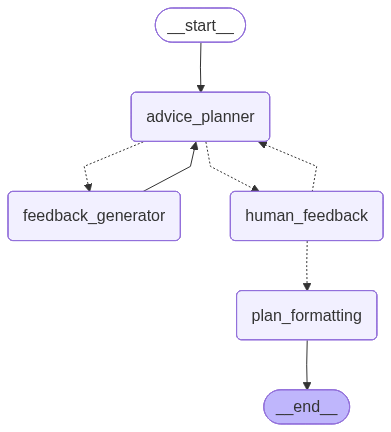

In [7]:
builder = StateGraph(state_schema=AdvicePlanningState, output_schema=PlanningOutputState)

builder.add_node("advice_planner", advice_planner)
builder.add_node("feedback_generator", feedback_generator)
builder.add_node("human_feedback", human_feedback)
builder.add_node("plan_formatting", plan_formatting)

builder.add_edge(START, "advice_planner")
builder.add_conditional_edges("advice_planner", continue_planning, ["feedback_generator", "human_feedback"])
builder.add_edge("feedback_generator", "advice_planner")
builder.add_conditional_edges("human_feedback", act_on_feedback, ["plan_formatting", "advice_planner"])
builder.add_edge("plan_formatting", END)

memory = MemorySaver()
advice_planning_subgraph = builder.compile(checkpointer=memory)
display(Image(advice_planning_subgraph.get_graph(xray=1).draw_mermaid_png()))

In [8]:
thread = {'configurable' : {"thread_id" : "thread-3"}}
problem = "I'm feeling very stressed at work because I don't like being sorrounded by many people in my office."

result = advice_planning_subgraph.invoke({"problem": problem, "max_steps": 2}, config=thread, stream_mode="values")

# First interrupt
print(result["__interrupt__"][0].value)

# User feedback input
user_input = input("\n-----\nProvide your response: ")

result = advice_planning_subgraph.invoke(Command(resume=user_input), config=thread, stream_mode="values")

# Second interrupt
print(result["__interrupt__"][0].value)

# 'No feedback'
user_input = input("\n-----\nProvide your response: ")

for event in advice_planning_subgraph.stream(Command(resume=user_input), config=thread, stream_mode="values"):
    steps =  event.get("steps", "")
    if steps:
        print("\n" + "-" * 10)
        for step in steps:
            print(step.step_summary)
            print("\n\n---\n\n")



---

Do you have any feedback for the current version of the wellbeing action plan? Type 'No feedback' if none.

Here is the wellbeing action plan:

- Step -
Theme: Workplace adjustments
Helpful tip: Consider discussing with your manager the possibility of having a more private workspace or flexible work hours to reduce the time spent in crowded environments.

- Step -
Theme: Therapy
Helpful tip: Engaging in cognitive-behavioral therapy (CBT) can help you develop coping strategies to manage stress and anxiety related to being in crowded spaces.


---

Do you have any feedback for the current version of the wellbeing action plan? Type 'No feedback' if none.

Here is the final wellbeing action plan:

- Step -
Theme: Workplace adjustments
Helpful tip: Consider discussing with your manager the possibility of having a more private workspace or flexible work hours to reduce the time spent in crowded environments.

- Step -
Theme: Therapy
Helpful tip: Explore alternative therapeutic approac

In [9]:
current_graph = advice_planning_subgraph.get_state(config=thread)
test_step = current_graph.values["steps"][1]
test_step

Step(theme='Therapy', helpful_tip='Explore alternative therapeutic approaches such as mindfulness-based stress reduction (MBSR) or Acceptance and Commitment Therapy (ACT) to help manage stress and anxiety in crowded environments. Additionally, consider using stress management apps or online courses that focus on relaxation techniques for more flexibility.')

### Research subgraph (Consultation process)

In [ ]:
class ConsultationState(MessagesState):
    problem: str # 
    step: Step # an individual step from the wellbeing action plan
    webquery: str # a query constructed for the web search/retrieval
    wikiquery: str # a query constructed for the Wikipedia search
    transcript: str # transcript from the consultation
    summary: str # summary of the consultation (for exceptionally long list of messages)
    max_cycles: int # Max number of |question| -> |answer| cycles
    cycles_counter : int # for tracking the cycles
    source_docs: Annotated[list, operator.add] # documents with knowledge the practitioner is using to provide answers
    sections: list # Final key we duplicate in outer state for Send() API 

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")


question_instructions = """# Identity and objectives:
You are a client who is having an appointment with a wellbeing practitioner. Your objective is to receive in-depth advice tailored to your problem:

{problem}

You finished your previous appointment with the following helpful advice form the practitioner:

{advice}

# Follow these steps:
1. Review your problem.
2. Review the piece of advice you have previously received.
2. Review your current conversation with the practitioner.
3. Review the (optional) summary of the conversation with the practitioner:

{summary}

3. Create a persona that fits the problem you came to discuss and stay in your character throughout the consultation.
3. Begin by greeting the practitioner and ask a follow up question regarding the piece of advice you have received during the last appointment.
4. Continue asking questions until you think the practitioner has offered enough help and clarification on the piece of advice.
5. Be curious, critical about practicalities of the advice you received and ask in-depth questions. Ask for real-world implementations.
6. IMPORTANT: When you feel you don't need more information and all your questions have been answered, finish the consultation by stating: "Thank you and goodbye!"   
"""

def question_generator(state: ConsultationState):
    """Genarate a question for a single step in the wellbeing action plan."""

    problem = state["problem"]
    step = state["step"]
    conversation = state.get("messages", [])
    summary = state.get("summary", "")

    formatted_question_instructions = question_instructions.format(
        problem = problem,
        advice = step.step_summary,
        summary=summary
    )

    messages = [
        SystemMessage(content=formatted_question_instructions),
        AIMessage(content="Hello! What brings you here today?", name="practitioner")
    ]

    question = llm.invoke(messages + conversation)
    question.name = "client"

    return {"messages": [question]}


web_query_instructions = """# Identity and objectives:
You are an assistant specialised in creating quality and well-structured search queries for use in web-search. 
You will be given a conversation between a client and a wellbeing practitioner and your goal is to create a query based on that conversation. 

# Follow these steps:
1. Analyse the problem the client came to discuss with the practitioner:

{problem}

2. Analyse the conversation.
3. Analyse (optional) summary of the previous parts of the conversation:

{summary}

4. IMPORTANT: Pay particular attention to the final question posed by the client.
5. Convert this final question into a well-structured web search query"""

def web_query_constructor(state: ConsultationState):
    """Construct a web search query according to the expected output schema."""

    problem = state["problem"]
    conversation = state["messages"]
    summary = state.get("summary", "")

    formatted_query_instructions = web_query_instructions.format(
        problem=problem,
        summary=summary
    )

    structured_llm = llm.with_structured_output(SearchQuery)
    query = structured_llm.invoke([formatted_query_instructions] + conversation)

    return {"webquery": query.search_query}


wiki_query_instructions = """# Identity and objectives:
You are an assistant specialised in creating quality and well-structured search queries for use in Wikipedia search. 
You will be given a conversation between a client and a wellbeing practitioner and your goal is to create a query based on that conversation. 

# Follow these steps:
1. Analyse the problem the client came to discuss with the practitioner:

{problem}

2. Analyse the conversation.
3. Analyse (optional) summary of the previous parts of the conversation:

{summary}

4. IMPORTANT: Pay particular attention to the final question posed by the client.
5. Convert this final question into a well-structured Wikipedia search query
6. When constructing the query, use these pointers:
* Use specific, unique terms - Search "Fermi paradox" instead of "aliens exist"
* Include proper names when known - Search "Marie Curie radium" instead of "female scientist radioactivity"
* Add disambiguating context for common terms - Search "Python programming" instead of just "Python"
* Use the most common name or spelling - Search "World War II" instead of "Second World War" or "WW2"
* Combine key concepts with AND - Search "Einstein AND photoelectric" instead of "Einstein's work on light"
* Keep the queries short.
"""
def wiki_query_constructor(state: ConsultationState):
    """Construct a web search query according to the expected output schema."""

    problem = state["problem"]
    conversation = state["messages"]
    summary = state.get("summary", "")

    formatted_query_instructions = wiki_query_instructions.format(
        problem=problem,
        summary=summary
    )

    structured_llm = llm.with_structured_output(SearchQuery)
    query = structured_llm.invoke([formatted_query_instructions] + conversation)

    return {"wikiquery": query.search_query}


def websearch(state: ConsultationState):
    "Perform the websearch with constructed query and save the source docs"
    
    webquery = state["webquery"]

    tavily = TavilySearch(
        max_results=3,
        topic="general"
        )
    
    docs = tavily.invoke(input=webquery)

    def raw_content_snippet(doc, max_length=2000):
        """Limit the length of the scraped raw content."""
        
        if doc.get("raw_content", ""):
            if len(doc["raw_content"]) > max_length:
                return doc["raw_content"][:max_length]
            else:
                return doc["raw_content"]

    formatted_docs = "\n\n-----\n\n".join(
        [
            f'<Document source: {doc["url"]}, title: "{doc["title"]}"/>\n\n{doc.get("content", "")}\n\n{raw_content_snippet(doc)}\n</Document>'
            for doc in docs['results']
        ]
    )

    return {"source_docs": [formatted_docs]}


def wikisearch(state: ConsultationState):
    "Perform wikipedia search with constructed query and save the source docs"

    wikiquery = state["wikiquery"]

    docs = WikipediaLoader(
        query=wikiquery, 
        load_max_docs=3, 
        doc_content_chars_max=3500 # max char set to ~average word count of Wikipedia page in 2025
        ).load() 
    
    formatted_docs = "\n\n" + "-" * 5 + "\n\n".join(
        [
            f'<Document source: {doc.metadata["source"]}, title: "{doc.metadata["title"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    return {"source_docs": [formatted_docs]}


answer_instructions = """# Identity and objectives:
You are an expert wellbeing practitioner who is having an appointment with a client. Your goal is to answer all questions coming from your client, while taking into account:

- The client's problem they came to discuss with you:

{problem}

- The context (knowledge) that is available to you:

{context}

- The conversation you're having with the client.

# When answering the client's questions follow these steps:
1. Review the client's problem.
2. Review the context (knowledge) that is available to you. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.
3. Review your current conversation.
4. Review the (optional) summary of the earlier parts of the appointment:

{summary}

5. Begin by welcoming the client and move on to answering their questions based on the context (knowledge) that you have. Only use the information provided in the context. 
6. The context contains sources at the topic of each individual document.
7. Include these sources to your answer next to any relevant statements. For example, for source # 1 use [1]. 
8. List your sources in order at the bottom of your answer. [1] Source # 1, [2] Source # 2, etc
9. If the source is: <Document source: https://positivepsychology.com/mindfulness-based-stress-reduction-mbsr/>' then just list: 
        
[1] https://positivepsychology.com/mindfulness-based-stress-reduction-mbsr
        
10. Skip the addition of the brackets as well as the Document source preamble in your citation.""" 

def answer_generator(state: ConsultationState):
    "Generate the consultant's answer based on the source documents."
    
    problem = state["problem"]
    context = "\n\n-----\n\n".join([doc for doc in state["source_docs"]])
    summary = state.get("summary", "")
    conversation = state["messages"]
    cycles_counter = state.get("cycles_counter", 0)

    formatted_answer_instructions = answer_instructions.format(
        problem=problem,
        context=context,
        summary=summary
    )

    sys_message = [SystemMessage(content=formatted_answer_instructions)]

    answer = llm.invoke(sys_message + conversation)
    answer.name = "practitioner"

    cycles_counter += 1

    return {"messages": [answer]}


def save_the_transcript(state: ConsultationState):
    """Save the consultation transcript."""
    
    conversation = state["messages"]
    transcript = state.get("transcript", "")

    
    if transcript:
        new_entries = get_buffer_string(conversation[-2:])
    # If the transcript is empty
    else:
        new_entries = get_buffer_string([AIMessage(content="Hello! What brings you here today?", name="practitioner")] + conversation)

    transcript += f"\n{new_entries}"

    return {"transcript": transcript}


def continue_consultation(state: ConsultationState):
    """Conditional edge to decide if the consultation should continue or if it can end."""
    
    conversation = state["messages"]
    max_cycles = state.get("max_cycles", "3")
    cycles_counter = state["cycles_counter"]

    if cycles_counter >= max_cycles or "Thank you and goodbye!" in conversation[-2].content:
        return "consultation_writer"
    else:
        return "generate_summary"
    

summary_instructions = """# Identity and ojectives:
Your are an assistant specialised at summarising conversations.

# Follow these steps:
1. Review the history of conversation.
2. Review the (optional) previous summary:

{summary}

3. Summarise the history of conversation making sure to preserve all important details, including who said what.
4. IMPORTANT: If previous summary was supplied, extend it with the new one.
5. Do not exceed 200 words.
"""

def generate_summary(state: ConsultationState):
    """Generate a summary of the consultation if it runs too long."""

    conversation = state["messages"]
    summary = state.get("summary", "")
    
    summary_instructions_formatted = summary_instructions.format(summary=summary)

    if len(conversation) >= 6:
        summary = llm.invoke([summary_instructions_formatted] + conversation)
        messages_to_remove = [RemoveMessage(id=message.id) for message in conversation[:4]]
        return {"summary": summary, "messages": messages_to_remove}
    else:
        pass





def consultation_writer(state: ConsultationState):
    """Use the consultation transcript and source docs to write an actionable summary for the wellbeing action plan."""
    pass


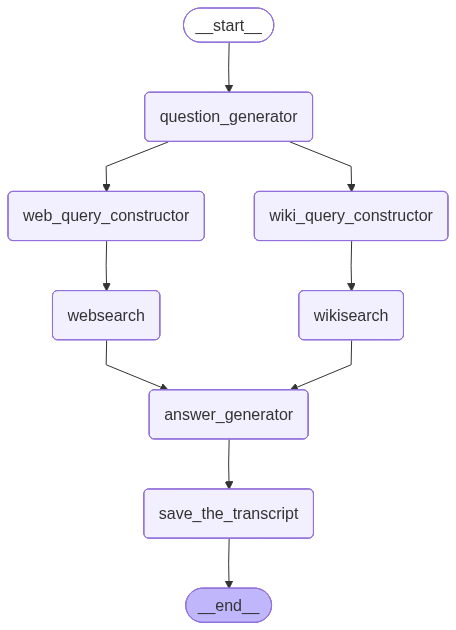

In [ ]:
builder = StateGraph(ConsultationState)

builder.add_node(question_generator)
builder.add_node(web_query_constructor)
builder.add_node(wiki_query_constructor)
builder.add_node(websearch)
builder.add_node(wikisearch)
builder.add_node(answer_generator)
builder.add_node(save_the_transcript)
builder.add_node(generate_summary)

builder.add_edge(START, "question_generator")
builder.add_edge("question_generator", "web_query_constructor")
builder.add_edge("question_generator", "wiki_query_constructor")
builder.add_edge("wiki_query_constructor", "wikisearch")
builder.add_edge("web_query_constructor", "websearch")
builder.add_edge(["websearch", "wikisearch"], "answer_generator")
builder.add_edge("answer_generator", "save_the_transcript")
builder.add_edge("save_the_transcript", "generate_summary")

test_graph = builder.compile()

display(Image(test_graph.get_graph().draw_mermaid_png()))

In [17]:
problem = "I'm feeling very stressed at work because I don't like being sorrounded by many people in my office. At the same time I can't work from home."

for chunk in test_graph.stream({"problem": problem, "step": test_step}):
    print(chunk)

{'question_generator': {'messages': [AIMessage(content='Hello! I wanted to follow up on our last session. You mentioned exploring alternative therapeutic approaches like mindfulness-based stress reduction (MBSR) or Acceptance and Commitment Therapy (ACT) to help manage stress and anxiety in crowded environments. Could you explain a bit more about how these approaches work and how I might incorporate them into my daily routine?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 330, 'total_tokens': 398, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f64f290af2', 'id': 'chatcmpl-CTF4Ye0WqZc2havyXMKv7SW4LpGHh', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, name='client', id='run--7547

In [13]:
# def run_with_multiple_interrupts(graph, initial_input, config):
#     """Run graph with support for multiple interruptions"""
    
#     # Initial invocation
#     result = graph.invoke(initial_input, config=config)
    
#     # Keep processing interruptions until complete
#     while "__interrupt__" in result and result["__interrupt__"]:
#         # Get the interrupt message
#         interrupt_message = result["__interrupt__"][0].value
#         print(interrupt_message)
        
#         # Get user input
#         user_input = input("\n-----\nProvide your response: ")
        
#         # Resume and get new result
#         result = graph.invoke(Command(resume=user_input), config=config)
        
#         # Process any intermediate outputs if needed
#         steps = result.get("steps", "")
#         if steps:
#             for step in steps:
#                 print(step.step_summary)
#                 print("\n\n---\n\n")
    
#     return result

# # Usage
# thread = {'configurable': {"thread_id": "121"}}
# problem = "I'm feeling very stressed at work because I don't like being surrounded by many people in my office."

# final_result = run_with_multiple_interrupts(
#     graph,
#     {"problem": problem, "max_steps": 5},
#     config=thread
# )